# 🧠 Flask Service Testing Notebook for OHLCV Models

This notebook is designed to test the Flask API that serves the trained machine learning models. The service runs inside a Docker container, exposing an HTTP endpoint for predictions.

---

## 🚀 How to Start the Prediction Service

Before running the cells below, make sure the Flask service is running. From your project root, execute the following commands in your terminal:

### Build the Docker image
**docker build -t ohlcv-flask-app -f deployment/flask/Dockerfile .**

### Run the Flask service inside a container

**docker run -it --rm -p 9696:9696 ohlcv-flask-app **

Once the service is running and listening on http://0.0.0.0:9696, you can proceed to execute the next cells in this notebook to send test requests.

**(THIS NOTEBOOK CAN ALSO BE USED TO TEST THE KUBERNETIES DEPLOYMENT)**

### Imports

In [87]:
import requests
from PIL import Image
import io
import base64
import matplotlib.pyplot as plt
import numpy as np


### Load and display the image

In [88]:
# Replace with the path to the image you want to test
img_path = "../../dataset/test/input/1a247043-c4f1-455c-9386-9a949b46feda.png"

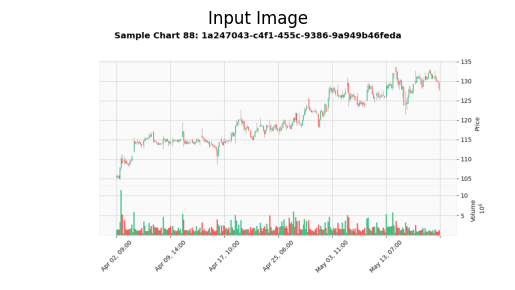

In [89]:
# Load image
img = Image.open(img_path).convert("RGB")

# Display
plt.imshow(img)
plt.title("Input Image")
plt.axis("off")
plt.show()

### Send POST request to your API

In [90]:
url = "http://localhost:9696/predict_image"

with open(img_path, "rb") as f:
    files = {"file": f}  # must match 'file' in Flask request.files
    response = requests.post(url, files=files)

if response.status_code == 200:
    print("Prediction successful!")
    result = response.json()
else:
    print("Error:", response.status_code, response.text)

Prediction successful!


### Decode predicted mask

In [91]:
# Decode the base64 outputs and convert to PIL images
def base64_to_image(b64_string):
    decoded = base64.b64decode(b64_string)
    return Image.open(io.BytesIO(decoded))

if response.status_code == 200:
    h_img = base64_to_image(result['horizontal_unet'])
    r_img = base64_to_image(result['unet_ray'])

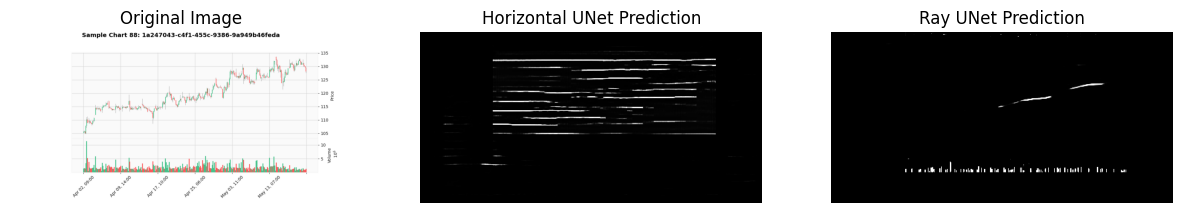

In [92]:
if response.status_code == 200:
    original = Image.open(img_path)
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    axs[0].imshow(original)
    axs[0].set_title("Original Image")
    axs[0].axis('off')
    
    axs[1].imshow(h_img)
    axs[1].set_title("Horizontal UNet Prediction")
    axs[1].axis('off')
    
    axs[2].imshow(r_img)
    axs[2].set_title("Ray UNet Prediction")
    axs[2].axis('off')
    
    plt.show()

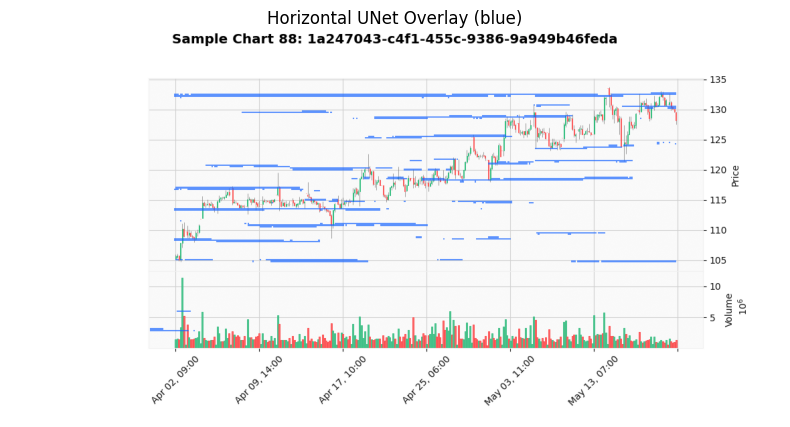

In [93]:
# Resize horizontal mask to match original image (keep binary)
h_mask_resized = h_img.convert("L").resize(img.size, resample=Image.NEAREST)
h_mask_np = (np.array(h_mask_resized) > 128)  # boolean mask

# Convert original image to numpy [0,1]
img_np = np.array(img) / 255.0

# Create overlay
overlay_h = img_np.copy()
overlay_h[h_mask_np] = [0.1, 0.4, 1.0]  # blue

# Blend original + overlay
alpha = 0.7
blended_h = (1 - alpha) * img_np + alpha * overlay_h

# Display
plt.figure(figsize=(12, 5))
plt.imshow(blended_h)
plt.title("Horizontal UNet Overlay (blue)")
plt.axis("off")
plt.show()

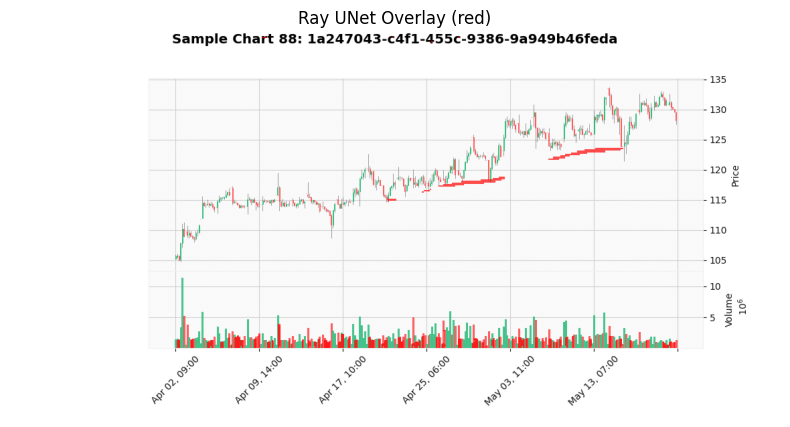

In [94]:
# Resize ray mask to match original image (keep binary)
r_mask_resized = r_img.convert("L").resize(img.size, resample=Image.NEAREST)
r_mask_np = (np.array(r_mask_resized) > 128)  # boolean mask

# Create overlay
overlay_r = img_np.copy()
overlay_r[r_mask_np] = [1.0, 0.0, 0.0]  # red

# Blend original + overlay
blended_r = (1 - alpha) * img_np + alpha * overlay_r

# Display
plt.figure(figsize=(12, 5))
plt.imshow(blended_r)
plt.title("Ray UNet Overlay (red)")
plt.axis("off")
plt.show()